In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(231)
print(tf.__version__)

import time
from matplotlib import pyplot as plt

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [354]:
hparams = tf.contrib.training.HParams(
    batch_size=100,
    in_seq_len=61,
    input_dim=5,
    out_seq_len=61,
    output_dim=1,
    num_layers=2,
    neurons_unit=32,
    learning_rate = 0.001,
    lr_decay = 1,
    lambd = 1e-6,
    datagen = 'prodn',
    logs_path = '/tmp/tensorflow_logs')

### Define Data Generator

In [395]:
# Load production dataset
if hparams.datagen == 'prodn':
    prodn = pd.read_pickle('../full_6d.pkl').values
    dataset = np.nan_to_num(prodn)[:10000]
    mask = np.isfinite(prodn)[:10000]

# Create synthetic sine wave data
if hparams.datagen == 'sin':
    dataset = np.zeros((hparams.batch_size, 10 * hparams.in_seq_len))
    dataset[1:,0] = np.random.randn(hparams.batch_size-1)
    for i in range(dataset.shape[1] - 1):
        dataset[:,i+1] = dataset[:,i] + 2 * np.pi / hparams.in_seq_len
    dataset = np.sin(dataset) + 1
    mask = np.ones_like(dataset)

# Reshape data
in_len, out_len = hparams.in_seq_len, hparams.out_seq_len
end_pos = in_len * (hparams.input_dim - 1) + 1

# x.shape = (n_obs, in_seq_len, input_dim)
x = np.array([dataset[:,pos:pos+in_len] for pos in range(0,end_pos,hparams.in_seq_len)])
x = np.rollaxis(x, 0, 3) / np.max(dataset)
x = x[:,:,:,np.newaxis]

y =   dataset[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis] / np.max(dataset)
y_mask = mask[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis]

del(dataset, mask)
print(x.shape, y.shape, y_mask.shape)

(10000, 61, 5, 1) (10000, 61, 1) (10000, 61, 1)


In [396]:
dataset = tf.data.Dataset.from_tensor_slices((x.astype(np.float32), y.astype(np.float32), y_mask.astype(np.float32)))
dataset = dataset.batch(hparams.batch_size, drop_remainder=True)

### Define Model

In [405]:
class Model(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim):
        super(Model, self).__init__()
        # store hparams
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.period     = period

        """self.pad_3x1 = tf.keras.layers.ZeroPadding2D(((1,1),(0,0)))
        self.pad_5x1 = tf.keras.layers.ZeroPadding2D(((2,2),(0,0)))"""
        
        # define model
        self.conv1_1x1 = tf.keras.layers.Conv2D(32, (1,input_dim))
        self.conv1_3x1 = tf.keras.layers.Conv2D(32, (3,input_dim), padding='valid')
        self.conv1_5x1 = tf.keras.layers.Conv2D(32, (5,input_dim), padding='valid')

        self.conv1_cat = tf.keras.layers.Conv2D(32, (1,1), activation='relu')
        self.conv1_smooth1 = tf.keras.layers.Conv2D(32, (3,1), activation='relu')
        self.conv1_smooth2 = tf.keras.layers.Conv2D(16, (3,1), activation='relu')
        
        #self.fc_out = tf.keras.layers.Dense(period, activation='relu', bias_initializer='ones')
        self.fc_out = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))


    def call(self, x, mask):
        """l1_1 = self.conv1_1x1(x)
        l1_3 = self.pad_3x1(x)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = self.pad_5x1(x)
        l1_5 = self.conv1_5x1(l1_5)"""

        l1_1 = self.conv1_1x1(x)
        l1_3 = tf.concat((x[:,-1:,:,:], x, x[:,:1,:,:]), axis=1)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = tf.concat((x[:,-2:,:,:], x, x[:,:2,:,:]), axis=1)
        l1_5 = self.conv1_5x1(l1_5)
        
        l1_c = tf.concat((l1_1, l1_3, l1_5), axis=-1)
        l1_c = self.conv1_cat(l1_c)
        l1_s = self.conv1_smooth1(l1_c)
        l1_s = self.conv1_smooth2(l1_s)
        
        l1_fc = tf.keras.backend.batch_flatten(l1_s)
        l1_fc = self.fc_out(l1_fc)
        
        return tf.keras.backend.expand_dims(l1_fc, axis=-1) * mask

In [455]:
loss_function(target, p, m.variables, inp)

(<tf.Tensor: id=23640829, shape=(), dtype=float32, numpy=0.00371566>,
 <tf.Tensor: id=23640673, shape=(), dtype=float32, numpy=0.0033971965>)

### Train Model

In [454]:
def loss_function(real, preds, variables, inputs, lambd = 1e-6):
    # Calculate OLS loss
    mse_loss = tf.losses.mean_squared_error(labels=real, predictions=preds)
    
    sum_mse_loss = tf.losses.mean_squared_error(tf.reduce_mean(real,  axis=(0,2)),
                                                tf.reduce_mean(preds, axis=(0,2)))
    
    smoothing_loss = tf.losses.mean_squared_error(labels=tf.concat((inputs[:,-1,-1,0:1], preds[:,:-1,0]), axis=-1),
                                                    predictions=preds[:,:,0])

    # Add L2 Regularisation
    l2_loss = 0
    for var in variables:
        l2_loss += lambd * tf.reduce_sum(var ** 2)

    #accuracy, loss = mse_loss, mse_loss + sum_mse_loss + l2_loss
    #accuracy, loss = mse_loss, mse_loss + l2_loss
    accuracy, loss = mse_loss, mse_loss + smoothing_loss + l2_loss
    
    return loss, accuracy

In [456]:
def train_model(model, optimizer, dataset, hparams, epochs = 10, verbose = True):

    training_run_start = time.time()
    stats = []

    for epoch in range(epochs):
        epoch_start = time.time()

        total_loss, total_accuracy = 0, 0

        for (batch, (inp, targ, mask)) in enumerate(dataset):

            with tf.GradientTape() as tape:
                predictions = model(inp, mask)
                loss, accuracy = loss_function(targ, predictions, model.variables, inp)

            # update statistics
            total_loss += loss
            total_accuracy += accuracy

            # update gradients
            variables = model.variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        if verbose:
            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                100 * total_loss / (batch+1), 100 * total_accuracy / (batch+1)))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - epoch_start))
        
        # apply learning rate decay
        optimizer._lr *= hparams.lr_decay
        stats.append([total_loss / (batch+1), total_accuracy / (batch+1), time.time() - epoch_start])
    
    return total_loss / (batch+1), total_accuracy / (batch+1), time.time() - training_run_start, np.array(stats)

Epoch 1 Loss 0.1172 Accuracy 0.0903
Time taken for 1 epoch 7.3975 sec

Epoch 2 Loss 0.0482 Accuracy 0.0295
Time taken for 1 epoch 7.1257 sec

Epoch 3 Loss 0.0411 Accuracy 0.0252
Time taken for 1 epoch 7.4825 sec

Epoch 4 Loss 0.0383 Accuracy 0.0241
Time taken for 1 epoch 7.5187 sec

Epoch 5 Loss 0.0359 Accuracy 0.0233
Time taken for 1 epoch 6.8593 sec

Loss 0.0359 Accuracy 0.0233 Time 36.3854


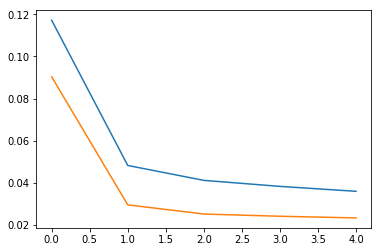

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_133 (ZeroPadd multiple                  0         
_________________________________________________________________
zero_padding2d_134 (ZeroPadd multiple                  0         
_________________________________________________________________
conv2d_280 (Conv2D)          multiple                  384       
_________________________________________________________________
conv2d_281 (Conv2D)          multiple                  512       
_________________________________________________________________
conv2d_282 (Conv2D)          multiple                  416       
_________________________________________________________________
conv2d_283 (Conv2D)          multiple                  3616      
_________________________________________________________________
conv2d_284 (Conv2D)          multiple                  3104      
__________

In [457]:
# Run a training batch
tf.set_random_seed(230) # Set seed

# Initialise model and optimiser
model_ = Model(hparams.input_dim, hparams.in_seq_len, hparams.output_dim)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = train_model(model_, optimizer, dataset, hparams, epochs=5, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(100*stats[:,:2])
plt.show()

model.summary()

In [513]:
train_model(model_, optimizer, dataset, hparams, epochs=5, verbose=True)

Epoch 1 Loss 0.0171 Accuracy 0.0141
Time taken for 1 epoch 7.2820 sec

Epoch 2 Loss 0.0170 Accuracy 0.0139
Time taken for 1 epoch 7.1406 sec

Epoch 3 Loss 0.0169 Accuracy 0.0139
Time taken for 1 epoch 7.2474 sec

Epoch 4 Loss 0.0169 Accuracy 0.0138
Time taken for 1 epoch 7.2052 sec

Epoch 5 Loss 0.0169 Accuracy 0.0138
Time taken for 1 epoch 7.2085 sec



(<tf.Tensor: id=36593761, shape=(), dtype=float32, numpy=0.00016874202>,
 <tf.Tensor: id=36593762, shape=(), dtype=float32, numpy=0.00013825076>,
 36.085147857666016,
 array([[1.71072665e-04, 1.40592383e-04, 7.28220201e+00],
        [1.69967680e-04, 1.39436816e-04, 7.14076400e+00],
        [1.69353050e-04, 1.38839241e-04, 7.24757981e+00],
        [1.68986444e-04, 1.38485149e-04, 7.20586801e+00],
        [1.68742015e-04, 1.38250762e-04, 7.20862174e+00]]))

### Make Predictions

(100, 61, 1) (100, 61, 1)


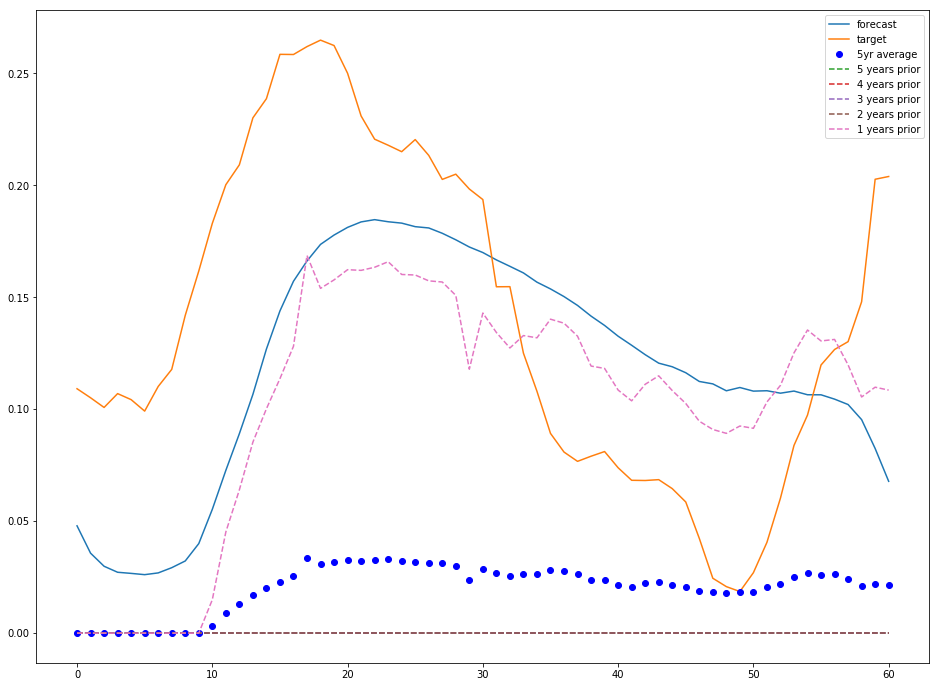

In [514]:
# empty string to store our results
TARGET_INDEX = 74
START_POINT = 0

_, (inp, target, mask) = enumerate(dataset).__next__()

forecast = model_(inp, mask)

print(forecast.shape, target.shape)

# show target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i years prior' % (5-i))
plt.legend()
plt.show()

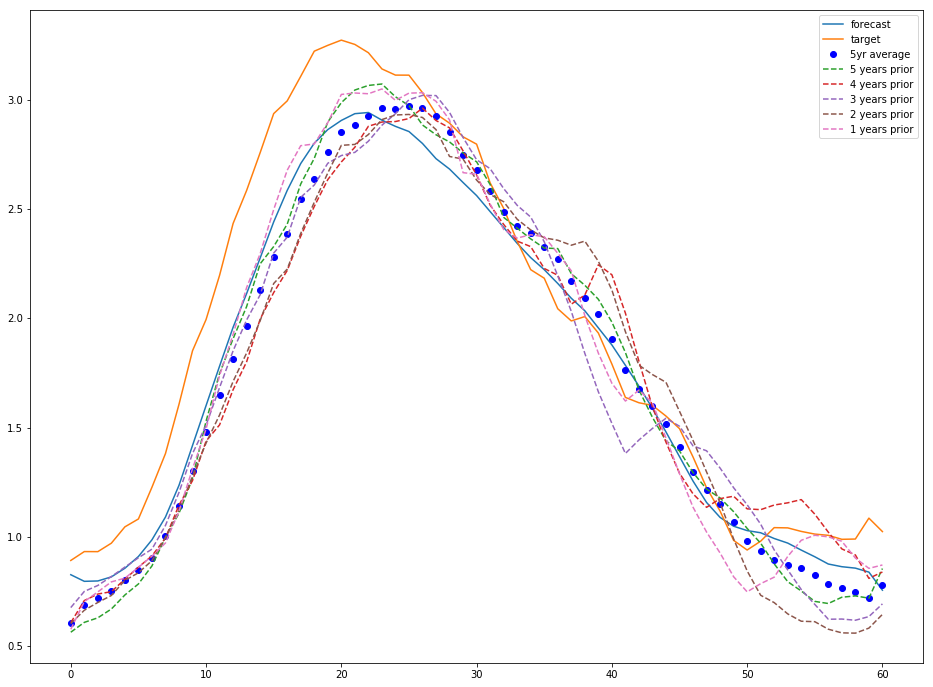

In [515]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=(0,2)), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=(0,3))[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

In [508]:
l_ = np.sum((forecast - target) ** 2, axis=(1,2))
l_.argsort()

array([ 0, 45, 46, 47, 48, 98, 53, 54, 56, 57, 61, 62, 64, 65, 66, 71, 75,
       77, 81, 83, 85, 89, 94, 95, 96, 97, 43, 36, 49, 22,  1, 12, 24,  3,
       16, 15, 13,  4, 23, 28, 51, 21, 84,  7, 68, 35, 34, 52, 82,  9, 92,
       76, 88, 40, 93, 17, 32, 69, 59, 60,  6, 79, 27, 19, 10, 70, 26, 41,
       99,  2, 14, 42, 78, 20, 37, 80, 91, 30, 39, 18, 31, 44, 29, 90, 86,
        5, 87, 33,  8, 58, 11, 50, 38, 72, 25, 67, 55, 73, 63, 74])

### Test Hyperparameters

In [145]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = Model(hparams.input_dim, hparams.in_seq_len, hparams.output_dim)
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model(model, optimizer, dataset, hparams, epochs = 40, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*100, accuracy * 100, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.1699 Accuracy 0.1221 Time 31.7
Learning Rate -3.5000 Loss 0.0697 Accuracy 0.0524 Time 31.4
Learning Rate -3.0000 Loss 0.0780 Accuracy 0.0616 Time 29.6
Learning Rate -2.5000 Loss 0.1024 Accuracy 0.0816 Time 34.2
Learning Rate -2.0000 Loss 0.9187 Accuracy 0.6176 Time 37.7
Learning Rate -1.5000 Loss 1.6334 Accuracy 0.9189 Time 37.8
Learning Rate -1.0000 Loss 5.1407 Accuracy 0.9189 Time 36.7
Learning Rate -0.5000 Loss 44.3993 Accuracy 0.9189 Time 34.3
